In [ ]:
!pip install torchvision
!pip install lovely-tensors
!pip install pyhessian
!pip install tqdm
!pip install wandb

In [2]:
from torchvision import datasets, transforms
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt # prints important features of tensors instead of their values
import matplotlib.pyplot as plt 
from pyhessian import hessian
from torch.utils.data import DataLoader
from tqdm import tqdm

#import wandb 

#wandb.login()
lt.monkey_patch()
#wandb.init(project="Basin broadness of mnist solutions")


In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
class mnist_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")
model = mnist_nn().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()
#

def train(dataloader, model, loss_function, optimiser):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predictions = model(X)
        loss = loss_function(predictions, y)
        # Loss accumulates over all batches for an epoch
        train_loss += loss
        # zeros the grad after each batch, grad accumulates otherwise.
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        correct += (predictions.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    correct /= size
   # wandb.log({'train accuracy': 100 * correct, 'train loss': train_loss})
    print(f"\n- Train Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            predictions = model(X)
            test_loss += loss_function(predictions, y).item()
            correct += (predictions.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
 #   wandb.log({'test accuracy': 100 * correct, 'test loss': test_loss})
    print(f"- Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in tqdm(range(epochs)):
    train(train_loader, model, loss_function, optimiser)
    test(test_loader, model, loss_function)

In [5]:
from torch.nn.utils import stateless

total_params = 0
for p in model.parameters():
  total_params += torch.numel(p)

def concat_dataloader(dataloader) -> torch.tensor:
    X_full = []
    y_full = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        X_full.append(X), y_full.append(y)
    X_full = torch.cat(X_full, dim=0)
    y_full = torch.cat(y_full, dim=0)
    return X_full, y_full

X, y = concat_dataloader(train_loader)

# wrapper function of loss as a function of params
def loss(*params):
    names = [n for n, _ in tuple(model.named_parameters())]
    param_dict = {n:p for n,p in zip(names,params)}
    preds = stateless.functional_call(model, param_dict, X)
    return loss_function(preds,y)

def flatten_hessian(
    *H : tuple
    ) -> torch.tensor([total_params, total_params]):
  H = H[0]
  shapes = [len(list(p.size())) for p in model.parameters()]
  columns = [0] * len(shapes)
  rows = [0] * len(shapes)
  for i in range(len(shapes)):
    for j in range(len(shapes)):
      columns[j] = H[i][j].flatten(start_dim = 0, end_dim = shapes[i] - 1).flatten(start_dim = 1)
    rows[i] = torch.cat(columns, dim = 1)
  return torch.cat(rows, dim = 0)

H = flatten_hessian(torch.autograd.functional.hessian(loss, tuple(model.parameters())))


In [6]:
print(total_params)

7850


In [7]:
# this is very expensive to run perhaps there is a way to numerically find this
eigenvalues, eigenvectors = torch.linalg.eig(H)
print(type(eigenvalues))

In [8]:
J = torch.autograd.functional.jacobian(loss, tuple(model.parameters()))
J = torch.flatten(J[0])

In [21]:
import math
# basin broadness metric is the fuzzy Gaussian volume from https://www.lesswrong.com/posts/QPqztHpToij2nx7ET/hessian-and-basin-volume
# radius of the elipsoid around the second order approximation of the loss at a local minimum 
# not sure what values of k,l,sigma are reasonable yet
def broadness_metric(
    H, k = 1., l = 0.00001, sigma = 1., n = total_params
    ) -> float:
    # volume of an n-sphere. For const number of params and threshold this is a constant
    # so we can just rescale and ignore the numerator
    # unit_sphere_volume = math.pi(n/2)^2/math.gamma(n/2 + 1)
    # numerator = unit_sphere_volume * (2 * T) ** (n/2)
    numerator = 1.
    return numerator / torch.sqrt( torch.det(H + (l + k / sigma **2 ) * torch.eye(n).to(device) ) )

print(broadness_metric(H))

# TODO: One could then plot this broadness metric (assuming it's a good measure) vs test set accuracy to demonstrate
# the correspondence between basin broadness and OOD performance of a NN. It is expected that these will be positively correlated.

# TODO: Does the correspondece between basin broadness and generality hold for other ML architecures ie. polynomial regression?
# Perhaps the reason neural networks generalize well is because: broad basins are likely final solutions and perform well OOD (see: grokking)
# Perhaps this is a non-trivial feature of nerual networks? 

# TODO: Ban certain features from being learned, train a neural network to the same loss as before.
# prediction: the basin broadness of the "unrestricted" and "natural" features will be larger
# this would be evidence for the natural abstraction hypothesis

tensor cuda:0 6.379e-05


# Hessian eigenvalue plot
Zero-value Hessian eigenvalues correspond to "flat" directions to a second order approximation. After training a small network for few epochs most eigenvalues are close to zero, implying many DOF in parameter space.

# Jacobian plot
At the minimum of a convex function (locally), Jacobian elements should be zero. As observe they are close to zero, probably implying we are close to but not excatly at a minimum due to stochastic effects.

# Hessian plot
Ten square submatrices are observed along the diagonal, probably corresponding to each output class. The near zero entries off diagonal suggest the loss can be decomposed into a sum of 10 terms each a function of mutually exclusive sets containing 1/10th the total parameters, as well as some smaller mixed terms of these sets. This fits a priori assumptions for simple neural networks.

# Substructure of submatrices of Hessian
As can be seen in the Hessian_zoomed graph of the top right diagonal sub matrix of the Hessian, there exists further regular structures. Perhaps these correspond to features of particular classes.

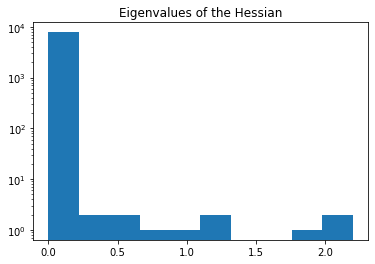

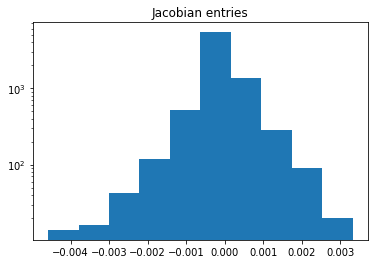

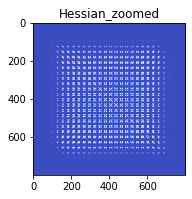

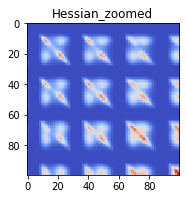

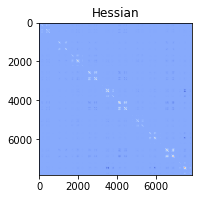

In [23]:
# uncomment the cell that finds eigenvalues to plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.hist(eigenvalues.cpu(), bins=10)
plt.title("Eigenvalues of the Hessian")
plt.yscale('log')
plt.show()

plt.hist(J.cpu(), bins = 10)
plt.yscale('log')
plt.title("Jacobian entries")
plt.show()

fig = plt.figure()

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(H.cpu()[:800,:800], interpolation='nearest', cmap=cm.coolwarm)
ax2.set_title('Hessian_zoomed')
plt.show()

fig = plt.figure()

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(H.cpu()[500:600,500:600], interpolation='nearest', cmap=cm.coolwarm)
ax2.set_title('Hessian_zoomed')
plt.show()

fig = plt.figure()

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(H.cpu(), interpolation='nearest', cmap=cm.coolwarm)
ax2.set_title('Hessian')
plt.show()


